# Response Time: Some Statistics
This is a notebook that explores response time of the tweets.
For questions, contact Alicia.

## Set-up:
### Imports:
Firth the necessary packages are imported:

In [1]:
# IMPORTS
import sys
sys.path.append("../DBL-Data-Challenge")

# Own functions
from database.connect import getConnection
from notebooks.response2 import response_time_id, response_time_calc, only_client_competitor, user_id_to_user, replied_sentiment, mentions_length, length
import numpy as np

# General imports
import numpy as np
import pandas as pd

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
sns.set()              # set Seaborn defaults
plt.rcParams['figure.figsize'] = [10, 5]   # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

KLM


Then a connection to a MySQL database is set up.

In [2]:
# Get connection
try:
    connection = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

### Creating the datafrane:
All the relevant data is fetched from the table. A list is used to keep track of the index of the columns.

In [3]:
# query relevant data and fetch it
cursor = connection.cursor()
query_columns = ['id', 'text', 'in_reply_to_status_id', 'timestamp_ms', 'user_id', 'language', 'mentions', 'airlines', 'sentiment']
query="""SELECT id, text, in_reply_to_status_id, timestamp_ms, user_id, language, mentions, airlines, sentiment 
            FROM tweets 
            WHERE user_id in (56377143, 106062176, 18332190, 22536055, 124476322, 26223583, 2182373406, 
                38676903, 1542862735, 253340062, 218730857, 45621423, 20626359)
            LIMIT 10000"""
cursor.execute(query)
tweets = cursor.fetchall()
print(len(tweets))

10000


A Pandas dataframe is created from this data, with the relevant columns for the analysis. The necessary functions are imported from response2.py

In [4]:
"""Creating the dataframe
    :columns: [response_time, tweet_sentiment, mentions, tweet_length]
    :values: [int (ms), float in range(-1, 1), list(str), int]
"""

# Creating the dataframe
df_columns = ['response_time', 'self_sentiment', 'replied_sentiment', 'user_name', 'language', 'mention_count', 'airline', 'tweet_length']
df_data = pd.DataFrame(columns=df_columns)

# Replace iteration with to dataframe.
counter = 0



# Read data from tweets with desired limit
for tuple in tweets:  
    dict = {'response_time': 'Null', 'self_sentiment': 'Null', 'replied_sentiment': 'Null', 'user_name': 'Null', 'language': 'Null', 'mention_count': 'Null', 'airline': 'Null', 'tweet_length': 'Null'}
        
    # Response time -> int, unit: ms
    try:
        dict['response_time'] = response_time_id(tuple[query_columns.index('id')], cursor) 
    except Exception:
        pass   

    # Sentiment detection -> float, in range(-1, 1)
    try:
        dict['self_sentiment'] = tuple[query_columns.index('sentiment')]
    except Exception:
        pass
    
    # Sentiment of parent tweet -> float, in range(-1, 1)
    try:
        dict['replied_sentiment'] = replied_sentiment(tuple[query_columns.index('in_reply_to_status_id')], cursor)
    except Exception:
        pass

    # Sentiment of parent tweet -> float, in range(-1, 1)
    try:
        dict['user_name'] = only_client_competitor(int(tuple[query_columns.index('user_id')]))
    except Exception:
        pass

    # Sentiment detection -> float, in range(-1, 1)
    try:
        dict['language'] = tuple[query_columns.index('language')]
    except Exception:
        pass

    # User mentions -> list(str, str, ...)
    try:
        dict['mention_count'] = mentions_length(tuple[query_columns.index('mentions')])
    except Exception:
        pass
    
     # Airline -> list(str)
    try:
        dict['airline'] = tuple[query_columns.index('airlines')]
    except Exception:
        pass   

    # Tweet length -> int
    try:    
        dict['tweet_length'] = length(tuple[query_columns.index('text')])
    except Exception:
        pass

    # Add to dataframe
    df_dict = pd.DataFrame([dict])
    df_data = pd.concat([df_data, df_dict], ignore_index=True)
    counter += 1
    #print(counter)

# Close connection
cursor.close()
connection.close()

df_data.count()

response_time        10000
self_sentiment       10000
replied_sentiment    10000
user_name            10000
language             10000
mention_count        10000
airline              10000
tweet_length         10000
dtype: int64

In [5]:
df_data.head()

,response_time,self_sentiment,replied_sentiment,user_name,language,mention_count,airline,tweet_length
0,no_reply,0.605432,Null,BritishAirways,en,1,[],138
1,no_reply,-0.406302,Null,BritishAirways,en,1,[],107
2,no_reply,-0.605935,Null,BritishAirways,en,1,[],105
3,no_reply,-0.810409,Null,BritishAirways,en,1,[],106
4,0.055099,-0.282238,-0.860331,OtherAirline,en,1,[],195


In [6]:

#df_data.to_csv('response_time_top_5hundredthousands.csv')

Since the value of most reponse times are "no_reply" and thus unlikely to see another value in the head, a double check is needed to see if everything was added correctly. The same applies to replied_sentiment.

In [7]:
#df_csv = pd.read_csv('data-csv/response_time_top_5hundredthousands.csv')
#df_csv.head()

df_csv = df_data
df_csv.head()


,response_time,self_sentiment,replied_sentiment,user_name,language,mention_count,airline,tweet_length
0,no_reply,0.605432,Null,BritishAirways,en,1,[],138
1,no_reply,-0.406302,Null,BritishAirways,en,1,[],107
2,no_reply,-0.605935,Null,BritishAirways,en,1,[],105
3,no_reply,-0.810409,Null,BritishAirways,en,1,[],106
4,0.055099,-0.282238,-0.860331,OtherAirline,en,1,[],195


In [8]:
# Check if the response time was added successfully
for i in range(0, len(df_csv.index)):
    if df_csv.loc[i, 'response_time'] != 'no_reply' and df_csv.loc[i, 'response_time'] != 'Null':
        print('Response Time: Successfully added!')
        print(f"   example: {df_csv.loc[i, 'response_time']}")
        break

Response Time: Successfully added!
   example: 0.05509888888888889


In [9]:
# Check if the response time was added successfully
for i in range(0, len(df_csv.index)):
    if df_csv.loc[i, 'replied_sentiment'] != 'Null':
        print('Replied Sentiment: Successfully added!')
        print(f"   example: {df_csv.loc[i, 'replied_sentiment']}")
        break

Replied Sentiment: Successfully added!
   example: -0.860331


In [10]:
# Check if the response time was added successfully
for i in range(0, len(df_csv.index)):
    if df_csv.loc[i, 'user_name'] != 'not_airline' and df_csv.loc[i, 'user_name'] != 'Null':
        print('User names: Successfully added!')
        print(f"   example: {df_csv.loc[i, 'user_name']}")
        break

User names: Successfully added!
   example: BritishAirways


## Statistics and Plots
First we give some basic statistics.

In [11]:
# Response time basic statistics
df_csv['response_time'].describe(include='all')

count        10000
unique        9516
top       no_reply
freq           475
Name: response_time, dtype: object

### EDA: Reply-rate Barplot:

In [12]:
print(len(df_csv.index))

10000


In [13]:
no_reply_count = df_csv['response_time'].value_counts()['no_reply']
reply_count = (len(df_csv.index) - no_reply_count)

df_reply_rate = pd.DataFrame([{'Reply': reply_count / len(df_csv.index), 'Not Reply': no_reply_count / len(df_csv.index)}])
df_reply_rate.head()

,Reply,Not Reply
0,0.9525,0.0475


Text(0, 0.5, 'Percentage [%]')

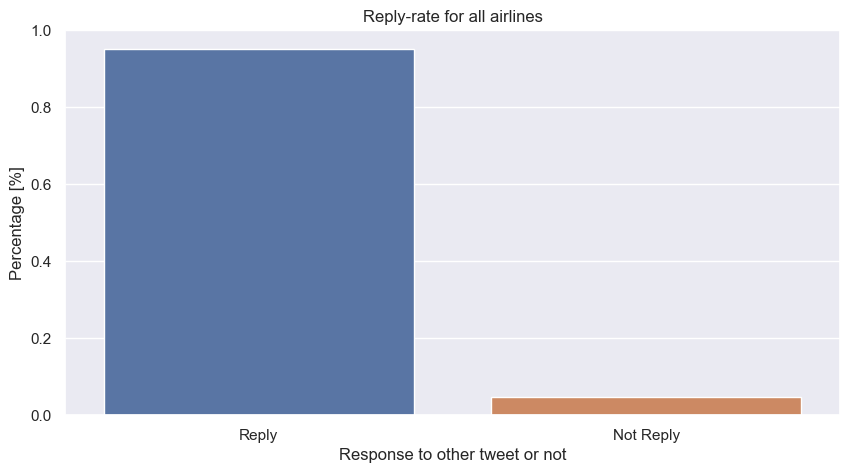

In [14]:
ax = sns.barplot(df_reply_rate)
ax.set_title("Reply-rate for all airlines")
ax.set_xlabel('Response to other tweet or not')
ax.set_ylabel('Percentage [%]')

### Response time scatter plot over parent sentiment, per airline
This provides an intersting insight into how the response time depends on the sentiment for differnt airlines.

In [15]:
# Root-dataframe
df_csv.head()

,response_time,self_sentiment,replied_sentiment,user_name,language,mention_count,airline,tweet_length
0,no_reply,0.605432,Null,BritishAirways,en,1,[],138
1,no_reply,-0.406302,Null,BritishAirways,en,1,[],107
2,no_reply,-0.605935,Null,BritishAirways,en,1,[],105
3,no_reply,-0.810409,Null,BritishAirways,en,1,[],106
4,0.055099,-0.282238,-0.860331,OtherAirline,en,1,[],195


In [16]:
# Select relevant parts of the dataframe
columns = ['response_time', 'replied_sentiment', 'user_name']
df_sentiment_responsetime = df_csv[columns][df_csv['response_time'] != 'no_reply']
df_sentiment_responsetime = df_sentiment_responsetime.round(decimals=3)
df_sentiment_responsetime.reset_index(inplace=True)
df_sentiment_responsetime.head()

,index,response_time,replied_sentiment,user_name
0,4,0.055099,-0.860331,OtherAirline
1,14,0.197676,0.673432,BritishAirways
2,19,0.197108,-0.005906,BritishAirways
3,23,0.277504,0.080313,AmericanAir
4,24,0.051593,0.823579,BritishAirways


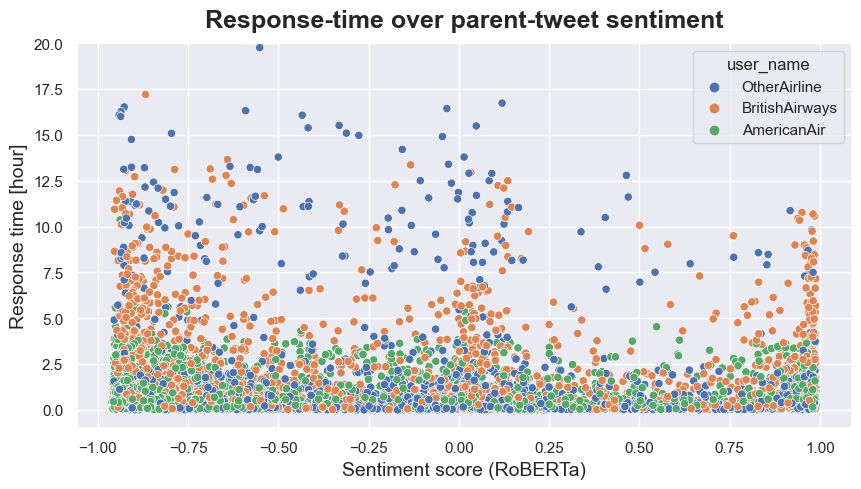

In [17]:
ax = sns.scatterplot(data=df_sentiment_responsetime, x='replied_sentiment', y='response_time', hue='user_name', alpha=1)
ax.set_title("Response-time over parent-tweet sentiment", size=18, weight='bold', y=1.02)
ax.set_xlabel('Sentiment score (RoBERTa)', size=14)
ax.set_ylabel('Response time [hour]', size=14)
ax.set_ylim(-1, 20);

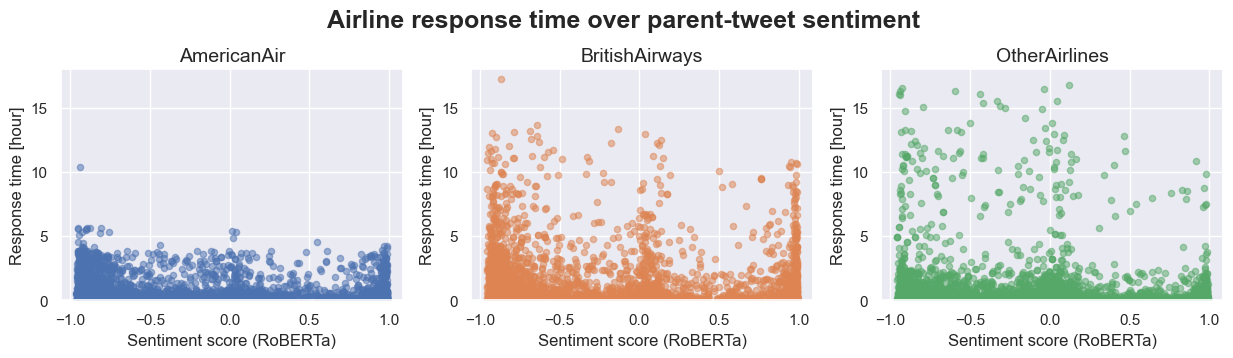

In [18]:
fig, ax = plt.subplots(ncols=3, squeeze=True, figsize=(15, 3))

# American Air
data_airline_0 = df_sentiment_responsetime[df_sentiment_responsetime['user_name'] == 'AmericanAir']
data_airline_0.plot(kind='scatter', x='replied_sentiment', y='response_time', alpha=0.5, ax=ax[0])  # too high

# British Airlines
data_airline_1 = df_sentiment_responsetime[df_sentiment_responsetime['user_name'] == 'BritishAirways']
data_airline_1.plot(kind='scatter', x='replied_sentiment', y='response_time', alpha=0.5, c='#DD8452', ax=ax[1])  # too high

# Other
data_airline_2 = df_sentiment_responsetime[df_sentiment_responsetime['user_name'] == 'OtherAirline']
data_airline_2.plot(kind='scatter', x='replied_sentiment', y='response_time', alpha=0.5, c='#55A868', ax=ax[2])  # too high

# For all plots
ax[0].set_ylim(0, 18)
ax[1].set_ylim(0, 18)
ax[2].set_ylim(0, 18)

ax[0].set_xlabel('Sentiment score (RoBERTa)', size=12)
ax[1].set_xlabel('Sentiment score (RoBERTa)' , size=12);
ax[2].set_xlabel('Sentiment score (RoBERTa)' , size=12);

ax[0].set_ylabel('Response time [hour]', size=12)
ax[1].set_ylabel('Response time [hour]' , size=12);
ax[2].set_ylabel('Response time [hour]' , size=12);

ax[0].set_title('AmericanAir', size=14)
ax[1].set_title('BritishAirways' , size=14);
ax[2].set_title('OtherAirlines' , size=14);

fig.suptitle('Airline response time over parent-tweet sentiment', size=18, weight='bold', y=1.08);


### Boxplot of reply time per competitor airplanes and in general.

In [19]:
df_sentiment_responsetime.head()

,index,response_time,replied_sentiment,user_name
0,4,0.055099,-0.860331,OtherAirline
1,14,0.197676,0.673432,BritishAirways
2,19,0.197108,-0.005906,BritishAirways
3,23,0.277504,0.080313,AmericanAir
4,24,0.051593,0.823579,BritishAirways


In [20]:
sentiment_labels = ['StrongNeg', 'Neg', 'MediumNeg', 'MildNeg', 'MildPos', 'MediumPos', 'Pos', 'StrongPos']
sentiment_bins = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]

df_sentiment_box = df_sentiment_responsetime

for i in range(0, len(df_sentiment_box.index)):
    for j in range(0, len(sentiment_bins)-1):
        sentiment = df_sentiment_box.loc[i, 'replied_sentiment']
        if sentiment > sentiment_bins[j] and sentiment < sentiment_bins[j+1]:
            df_sentiment_box.loc[i, 'replied_sentiment'] = sentiment_labels[j]
            break

In [21]:
df_sentiment_box.head()

,index,response_time,replied_sentiment,user_name
0,4,0.055099,StrongNeg,OtherAirline
1,14,0.197676,Pos,BritishAirways
2,19,0.197108,MildNeg,BritishAirways
3,23,0.277504,MildPos,AmericanAir
4,24,0.051593,StrongPos,BritishAirways


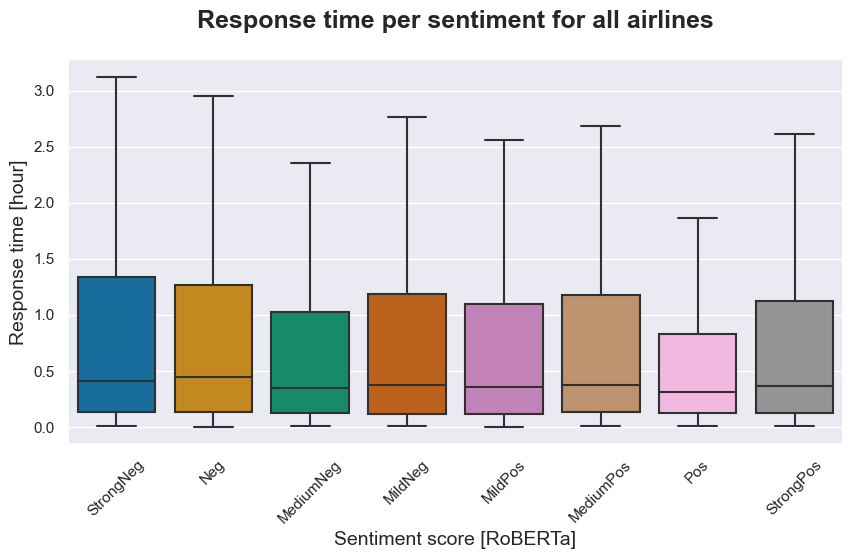

In [22]:
ax = sns.boxplot(data=df_sentiment_box, x='replied_sentiment', y='response_time', order = sentiment_labels, showfliers=False, palette='colorblind')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Sentiment score [RoBERTa]', size=14)
ax.set_ylabel('Response time [hour]', size=14)
ax.set_title('Response time per sentiment for all airlines', size=18, weight='bold', y=1.06);

### Stacked bar charts of reply time per competitor airplanes and in general.

In [23]:
df_sentiment_box.head()

,index,response_time,replied_sentiment,user_name
0,4,0.055099,StrongNeg,OtherAirline
1,14,0.197676,Pos,BritishAirways
2,19,0.197108,MildNeg,BritishAirways
3,23,0.277504,MildPos,AmericanAir
4,24,0.051593,StrongPos,BritishAirways


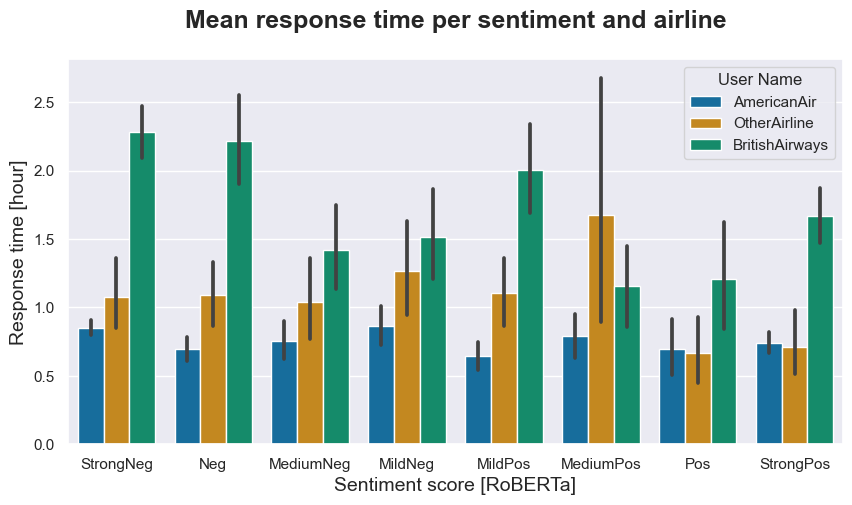

In [24]:
ax = sns.barplot(data=df_sentiment_box, x='replied_sentiment', y='response_time', hue='user_name', hue_order=['AmericanAir', 'OtherAirline', 'BritishAirways'], palette='colorblind', order=sentiment_labels)
ax.set_xlabel('Sentiment score [RoBERTa]', size=14)
ax.set_ylabel('Response time [hour]', size=14)
ax.legend(title='User Name')
ax.set_title('Mean response time per sentiment and airline', size=18, weight='bold', y=1.06);

### Strip plot 

In [25]:
df_sentiment_box.head()

,index,response_time,replied_sentiment,user_name
0,4,0.055099,StrongNeg,OtherAirline
1,14,0.197676,Pos,BritishAirways
2,19,0.197108,MildNeg,BritishAirways
3,23,0.277504,MildPos,AmericanAir
4,24,0.051593,StrongPos,BritishAirways


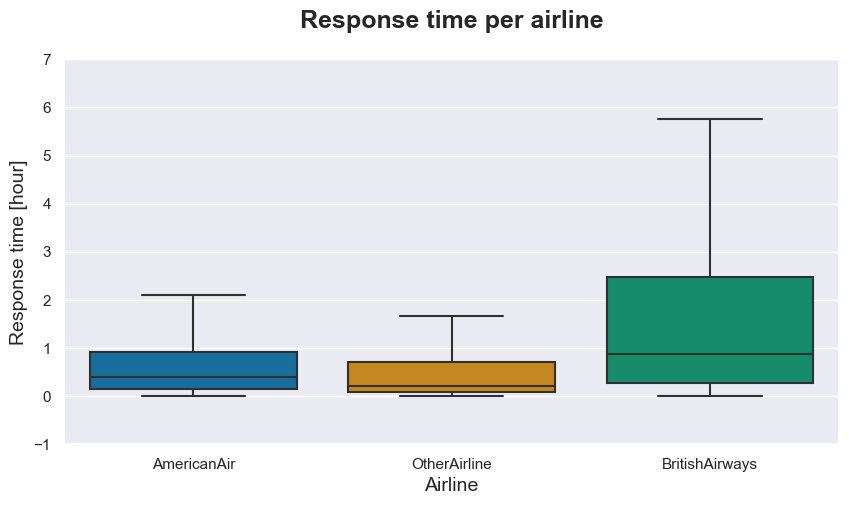

In [26]:
ax = sns.boxplot(data=df_sentiment_box, x='user_name', y='response_time', showfliers=False, order=['AmericanAir', 'OtherAirline', 'BritishAirways'], palette='colorblind')
ax.set_ylim(-1, 7)
ax.set_xlabel('Airline', size=14)
ax.set_ylabel('Response time [hour]', size=14)
ax.set_title('Response time per airline', size=18, weight='bold', y=1.06);


### Heat map of sentiment, replytime and denisty.

In [27]:
df_sentiment_heat = df_sentiment_box[columns]
df_sentiment_heat.head()

,response_time,replied_sentiment,user_name
0,0.055099,StrongNeg,OtherAirline
1,0.197676,Pos,BritishAirways
2,0.197108,MildNeg,BritishAirways
3,0.277504,MildPos,AmericanAir
4,0.051593,StrongPos,BritishAirways


In [39]:
df_sentiment_heat = df_sentiment_box[columns]
df_sentiment_heat.head()

columns = ['response_time', 'replied_sentiment', 'user_name']
reply_labels = ['[> 4 hours]', '[≈2 hours]', '[≈1 hour]', '[≈30 min]', '[≈20 min]', '[≈10 min]', '[≈7 min]', '[< 5 min]']

# 24, 2, 1, 30 min, 20 min, 10 min, 5 min
reply_bins = [4, 2, 1, 0.5, 0.33, 0.17, 0.08]

first_elem = 0
last_elem = len(reply_bins)

for i in range(0, len(df_sentiment_heat.index)):
    for j in range(0, len(reply_bins)+1):
        
        # The reply time in hours, of tweet
        reply = float(df_sentiment_heat.loc[i, 'response_time'])

        # If reply > 1 month
        if j==first_elem:
            if reply > reply_bins[j]:
                df_sentiment_heat.loc[i, 'response_time'] = reply_labels[j]
                break

        # If reply < 10 min
        elif j==last_elem:
            if reply < reply_bins[j-1]:
                df_sentiment_heat.loc[i, 'response_time'] = reply_labels[j]
                break
        
        # Else, find the interval
        else:
            if reply < reply_bins[j-1] and reply > reply_bins[j]:
                df_sentiment_heat.loc[i, 'response_time'] = reply_labels[j]
                break

df_sentiment_heat

/var/folders/2r/1pk5npwn5l541mm_rkjxq2_00000gn/T/ipykernel_37290/1012278324.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment_heat.loc[i, 'response_time'] = reply_labels[j]
/var/folders/2r/1pk5npwn5l541mm_rkjxq2_00000gn/T/ipykernel_37290/1012278324.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment_heat.loc[i, 'response_time'] = reply_labels[j]
/var/folders/2r/1pk5npwn5l541mm_rkjxq2_00000gn/T/ipykernel_37290/1012278324.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,response_time,replied_sentiment,user_name
0,[< 5 min],StrongNeg,OtherAirline
1,[≈10 min],Pos,BritishAirways
2,[≈10 min],MildNeg,BritishAirways
3,[≈10 min],MildPos,AmericanAir
4,[< 5 min],StrongPos,BritishAirways
...,...,...,...
9520,[< 5 min],StrongNeg,BritishAirways
9521,[> 4 hours],StrongPos,OtherAirline
9522,[≈30 min],StrongNeg,AmericanAir
9523,[≈30 min],MediumNeg,AmericanAir


In [40]:
df_sentiment_grouped = df_sentiment_heat.groupby(['response_time', 'replied_sentiment'])['user_name'].count().to_frame()
df_sentiment_grouped.head()

user_name
response_time replied_sentiment           
[< 5 min]     MediumNeg                117
              MediumPos                 51
              MildNeg                  140
              MildPos                  233
              Neg                      184

In [41]:
# Sort the rows in the right order
reply_labels.reverse()
df_sentiment_grouped = df_sentiment_grouped.reindex(reply_labels, level='response_time')
df_sentiment_grouped = df_sentiment_grouped.reindex(sentiment_labels, level='replied_sentiment')
df_sentiment_grouped.head()


user_name
response_time replied_sentiment           
[< 5 min]     StrongNeg                567
              Neg                      184
              MediumNeg                117
              MildNeg                  140
              MildPos                  233

In [42]:
df_sentiment_matrix = df_sentiment_grouped['user_name'].unstack().fillna(0)
df_sentiment_matrix

replied_sentiment,StrongNeg,Neg,MediumNeg,MildNeg,MildPos,MediumPos,Pos,StrongPos
response_time,,,,,,,,
[< 5 min],567,184,117,140,233,51,50,256
[≈7 min],543,154,115,118,193,41,40,214
[≈10 min],560,138,97,100,183,47,56,220
[≈20 min],356,115,67,84,111,29,26,157
[≈30 min],575,187,105,114,197,41,47,232
[≈1 hour],427,142,71,89,147,48,33,161
[≈2 hours],439,104,67,80,98,25,20,141
[> 4 hours],222,78,34,43,86,14,12,84


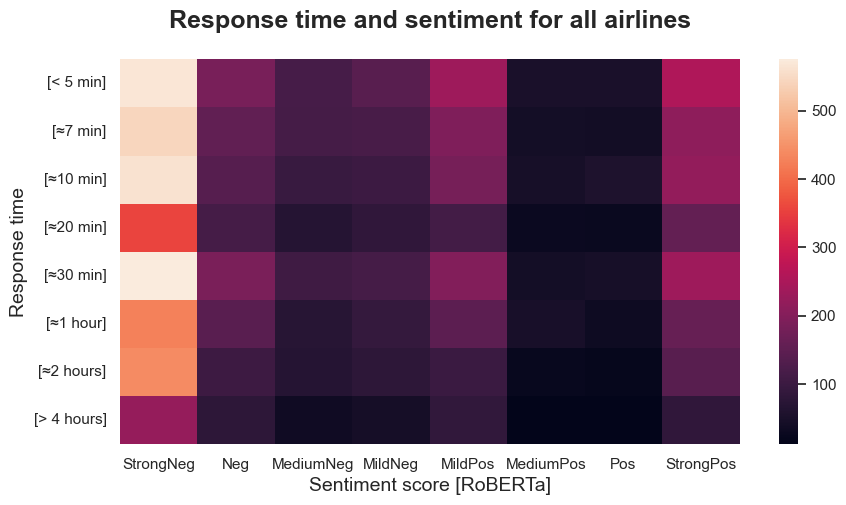

In [43]:
ax = sns.heatmap(data=df_sentiment_matrix)
ax.set_xlabel('Sentiment score [RoBERTa]', size=14)
ax.set_ylabel('Response time', size=14)
ax.set_title('Response time and sentiment for all airlines', size=18, weight='bold', y=1.06);

### Heatmap per airline

In [44]:
df_sentiment_heat.head()

,response_time,replied_sentiment,user_name
0,[< 5 min],StrongNeg,OtherAirline
1,[≈10 min],Pos,BritishAirways
2,[≈10 min],MildNeg,BritishAirways
3,[≈10 min],MildPos,AmericanAir
4,[< 5 min],StrongPos,BritishAirways


In [45]:
airline = 'AmericanAir'
df_sentiment_grouped_AA = df_sentiment_heat[df_sentiment_heat['user_name'] == airline].groupby(['response_time', 'replied_sentiment'])['user_name'].count().to_frame()
df_sentiment_grouped_AA.head()

airline = 'BritishAirways'
df_sentiment_grouped_BA = df_sentiment_heat[df_sentiment_heat['user_name'] == airline].groupby(['response_time', 'replied_sentiment'])['user_name'].count().to_frame()
df_sentiment_grouped_BA.head()

airline = 'OtherAirline'
df_sentiment_grouped_OA = df_sentiment_heat[df_sentiment_heat['user_name'] == airline].groupby(['response_time', 'replied_sentiment'])['user_name'].count().to_frame()
df_sentiment_grouped_OA.head()

user_name
response_time replied_sentiment           
[< 5 min]     MediumNeg                 69
              MediumPos                 30
              MildNeg                   95
              MildPos                  139
              Neg                      119

In [46]:
# Sort the rows in the right order

# airline = 'AmericanAir'
df_sentiment_grouped_AA = df_sentiment_grouped_AA.reindex(reply_labels, level='response_time')
df_sentiment_grouped_AA = df_sentiment_grouped_AA.reindex(sentiment_labels, level='replied_sentiment')

# airline = 'BritishAirways'
df_sentiment_grouped_BA = df_sentiment_grouped_BA.reindex(reply_labels, level='response_time')
df_sentiment_grouped_BA = df_sentiment_grouped_BA.reindex(sentiment_labels, level='replied_sentiment')

# airline = 'OtherAirline'
df_sentiment_grouped_OA = df_sentiment_grouped_OA.reindex(reply_labels, level='response_time')
df_sentiment_grouped_OA = df_sentiment_grouped_OA.reindex(sentiment_labels, level='replied_sentiment')

df_sentiment_grouped_OA.head()

user_name
response_time replied_sentiment           
[< 5 min]     StrongNeg                281
              Neg                      119
              MediumNeg                 69
              MildNeg                   95
              MildPos                  139

In [47]:
# Unstack the dataframe

# airline = 'AmericanAir'
df_sentiment_matrix_AA = df_sentiment_grouped_AA['user_name'].unstack().fillna(0)

# airline = 'BritishAirways'
df_sentiment_matrix_BA = df_sentiment_grouped_BA['user_name'].unstack().fillna(0)

# airline = 'OtherAirline'
df_sentiment_matrix_OA = df_sentiment_grouped_OA['user_name'].unstack().fillna(0)

df_sentiment_matrix_OA.head()

replied_sentiment,StrongNeg,Neg,MediumNeg,MildNeg,MildPos,MediumPos,Pos,StrongPos
response_time,,,,,,,,
[< 5 min],281,119,69,95,139,30,24,111
[≈7 min],258,91,65,70,108,18,17,90
[≈10 min],173,59,43,44,100,15,20,75
[≈20 min],80,26,27,46,61,8,12,42
[≈30 min],122,64,32,53,90,11,17,54


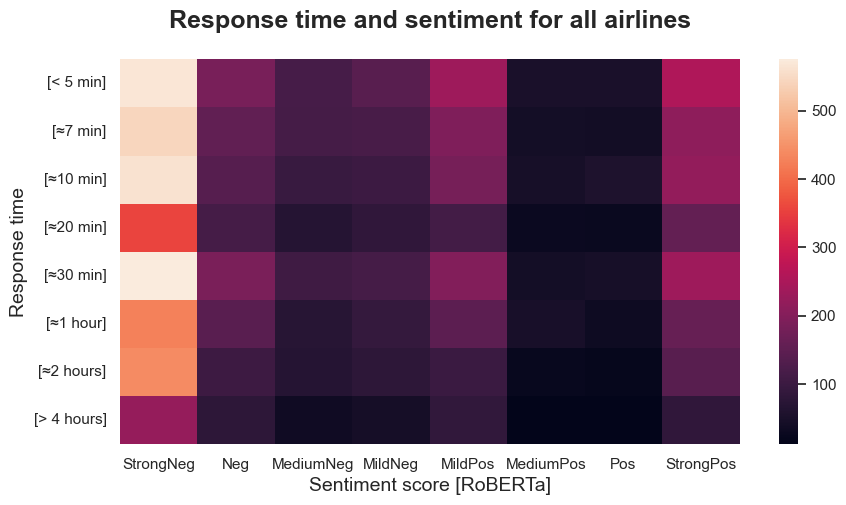

In [48]:
ax = sns.heatmap(data=df_sentiment_matrix)
ax.set_xlabel('Sentiment score [RoBERTa]', size=14)
ax.set_ylabel('Response time', size=14)
ax.set_title('Response time and sentiment for all airlines', size=18, weight='bold', y=1.06);

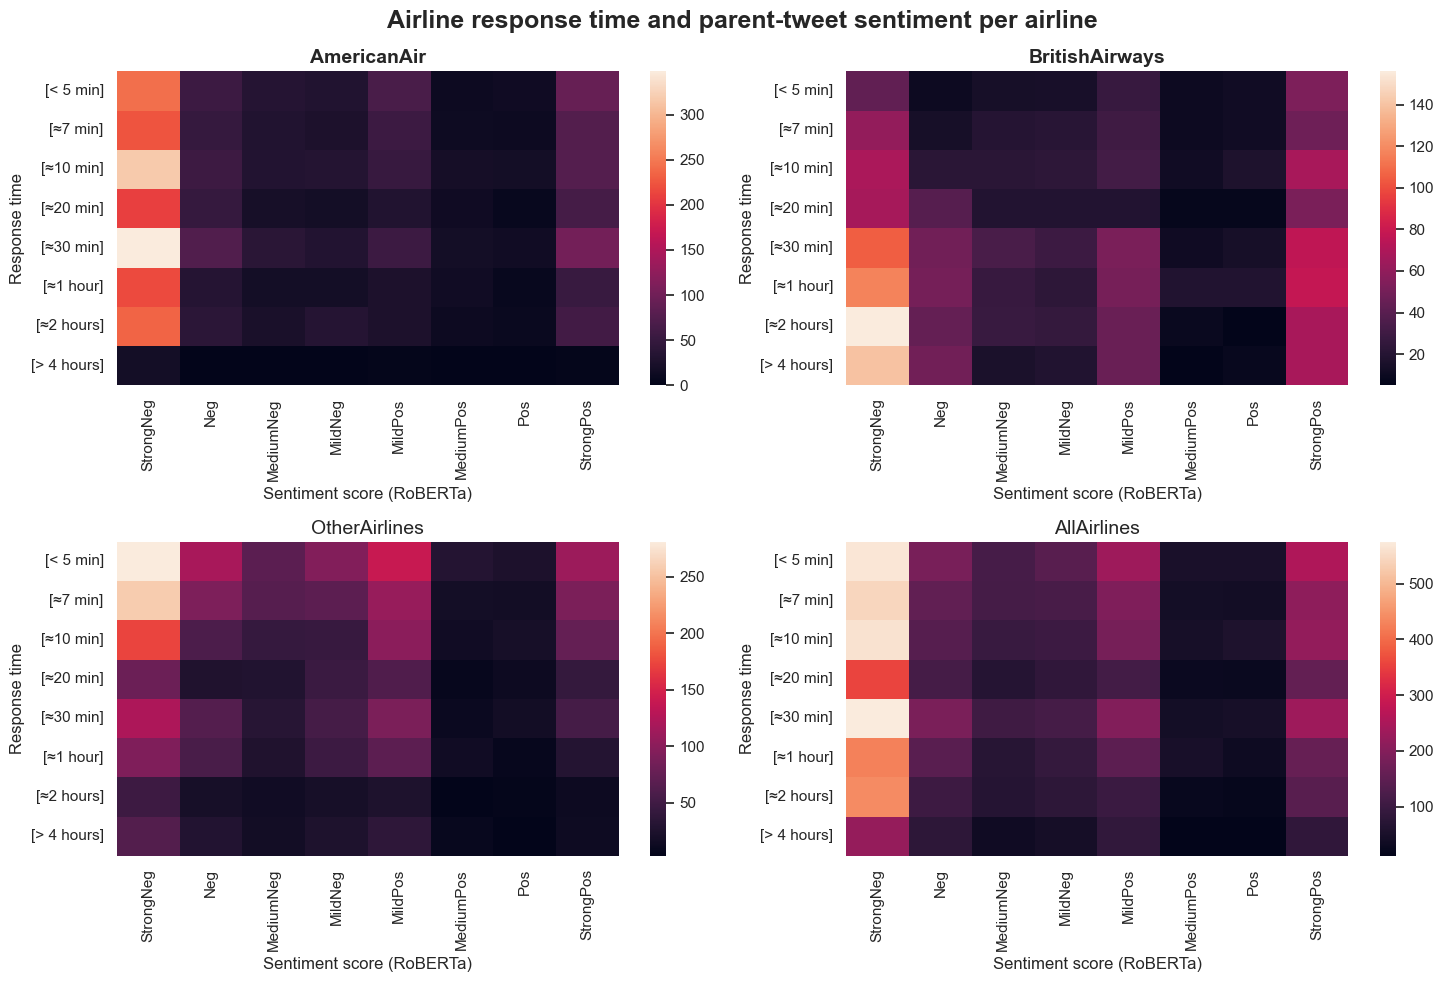

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=2, squeeze=True, figsize=(15, 10))

# American Air
sns.heatmap(data=df_sentiment_matrix_AA, ax=ax[0, 0])

# British Airlines
sns.heatmap(data=df_sentiment_matrix_BA, ax=ax[0, 1])

# Other Airline
sns.heatmap(data=df_sentiment_matrix_OA, ax=ax[1, 0])

# All airlines
sns.heatmap(data=df_sentiment_matrix, ax=ax[1, 1])

# LABELS
# For all plots
ax[0, 0].set_xlabel('Sentiment score (RoBERTa)', size=12)
ax[0, 1].set_xlabel('Sentiment score (RoBERTa)' , size=12);
ax[1, 0].set_xlabel('Sentiment score (RoBERTa)' , size=12);
ax[1, 1].set_xlabel('Sentiment score (RoBERTa)' , size=12);

ax[0, 0].set_ylabel('Response time', size=12)
ax[0, 1].set_ylabel('Response time' , size=12);
ax[1, 0].set_ylabel('Response time' , size=12);
ax[1, 1].set_ylabel('Response time' , size=12);

ax[0, 0].set_title('AmericanAir', size=14, weight='bold')
ax[0, 1].set_title('BritishAirways' , size=14, weight='bold');
ax[1, 0].set_title('OtherAirlines' , size=14);
ax[1, 1].set_title('AllAirlines' , size=14);

fig.suptitle('Airline response time and parent-tweet sentiment per airline', size=18, weight='bold')
fig.tight_layout();

In [ ]:
fig.supxlabel